### Setup

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use('ggplot')

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Dataset and Randomization

In [2]:
california_housing_dataframe = pd.read_csv(
    "https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocess the Data

In [3]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / 
                             california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

### Training set and Validation set

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training Examples Summary: ")
display.display(training_examples.describe())
print("Validation Examples Summary: ")
display.display(validation_examples.describe())
print("Training Targets Summary: ")
display.display(training_targets.describe())
print("Validation Targets Summary: ")
display.display(validation_targets.describe())

Training Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2645.5,539.2,1431.8,500.9,3.9,2.0
std,2.1,2.0,12.6,2209.7,424.0,1173.0,386.7,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1468.0,299.0,791.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.0,431.0,1163.5,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3141.0,646.0,1721.0,605.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.3,2639.2,540.0,1424.3,501.9,3.9,2.0
std,2.1,2.0,12.6,2107.0,415.4,1085.3,379.3,1.9,1.1
min,32.5,-124.2,1.0,18.0,3.0,8.0,2.0,0.5,0.0
25%,33.9,-121.7,18.0,1444.0,292.0,785.8,278.0,2.6,1.5
50%,34.2,-118.5,28.0,2133.0,439.0,1174.0,412.0,3.5,1.9
75%,37.7,-118.0,37.0,3173.5,653.0,1721.2,607.0,4.8,2.3
max,41.8,-114.3,52.0,26322.0,4952.0,12153.0,4616.0,15.0,41.3


Training Targets Summary: 


,median_house_value
count,12000.0
mean,207.5
std,116.2
min,15.0
25%,119.4
50%,180.1
75%,265.6
max,500.0


Validation Targets Summary: 


,median_house_value
count,5000.0
mean,206.7
std,115.5
min,15.0
25%,119.5
50%,180.8
75%,263.4
max,500.0


### Construct Feature Columns

In [5]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_features) 
                for my_features in input_features])

### Input Function

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Train Deep Neural Net Regressor Model

In [7]:
def train_nn_regressor_model(my_optimizer,
                             steps,
                             batch_size,
                             hidden_units,
                             training_examples,
                             training_targets,
                             validation_examples,
                             validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Create dnn_regressor object and configure it
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns = construct_feature_columns(training_examples),
        hidden_units = hidden_units,
        optimizer = my_optimizer
    )
    
    # Input functions
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train the dnn_regressor model in loop
    training_rmse = []
    validation_rmse = []
    print("Training model...")
    print("  RMSE (on training data & validation data): ")
    for period in range(0, periods):
        dnn_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Compute predictions
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions,
                                                                           training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,
                                                                             validation_targets))
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                  training_root_mean_squared_error,
                                                  validation_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training", color="magenta")
    plt.plot(validation_rmse, label="validation", color="g")
    plt.legend()
    
    print("Final RMSE (on training data): %s" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %s" % validation_root_mean_squared_error)
    return dnn_regressor

Training model...
  RMSE (on training data & validation data): 
    Period 01 : 172.06	167.31
    Period 02 : 161.37	157.67
    Period 03 : 166.27	160.91
    Period 04 : 156.25	152.53
    Period 05 : 155.89	151.34
    Period 06 : 152.75	150.34
    Period 07 : 148.88	144.71
    Period 08 : 145.01	141.93
    Period 09 : 142.26	139.60
    Period 10 : 142.73	138.28
Model training finished.
Final RMSE (on training data): 142.72954577001917
Final RMSE (on validation data): 138.27934813924855


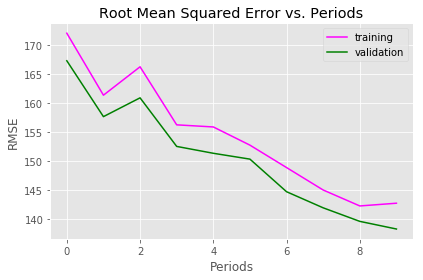

In [8]:
_ = train_nn_regressor_model(
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps = 5000,
    batch_size = 70,
    hidden_units = [10, 10],
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

### Linear Scaling

In [9]:
def linear_scale(series):
    min_value = series.min()
    max_value = series.max()
    scale = (max_value - min_value) / 2.0
    return series.apply(lambda x: ((x - min_value)/ scale) - 1.0)

linear_scale(california_housing_dataframe["total_rooms"])

3531    -0.9
5221    -0.9
4971    -0.9
9785    -0.9
3884    -0.8
        ... 
8206    -0.9
3629    -0.9
6243    -0.9
7236    -0.7
15047   -0.9
Name: total_rooms, Length: 17000, dtype: float64

### Normalize Linear Scale

In [10]:
def normalize_linear_scale(examples_dataframe):
    processed_features = pd.DataFrame()
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
    processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
    processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
    processed_features["population"] = linear_scale(examples_dataframe["population"])
    processed_features["households"] = linear_scale(examples_dataframe["households"])
    processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
    processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
    return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
display.display(normalized_dataframe.describe())

normalized_training_examples = normalized_dataframe.head(12000)
display.display(normalized_training_examples.describe())
normalized_validation_examples = normalized_dataframe.tail(5000)
display.display(normalized_validation_examples.describe())

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-0.3,-0.0,0.1,-0.9,-0.8,-0.9,-0.8,-0.5,-0.9
std,0.5,0.4,0.5,0.1,0.1,0.1,0.1,0.3,0.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.7,-0.5,-0.3,-0.9,-0.9,-1.0,-0.9,-0.7,-0.9
50%,-0.6,0.2,0.1,-0.9,-0.9,-0.9,-0.9,-0.6,-0.9
75%,0.1,0.3,0.4,-0.8,-0.8,-0.9,-0.8,-0.4,-0.9
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,-0.3,-0.0,0.1,-0.9,-0.8,-0.9,-0.8,-0.5,-0.9
std,0.5,0.4,0.5,0.1,0.1,0.1,0.1,0.3,0.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.7,-0.5,-0.3,-0.9,-0.9,-1.0,-0.9,-0.7,-0.9
50%,-0.6,0.2,0.1,-0.9,-0.9,-0.9,-0.9,-0.6,-0.9
75%,0.1,0.3,0.4,-0.8,-0.8,-0.9,-0.8,-0.4,-0.9
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,-0.3,-0.0,0.1,-0.9,-0.8,-0.9,-0.8,-0.5,-0.9
std,0.5,0.4,0.5,0.1,0.1,0.1,0.1,0.3,0.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.7,-0.5,-0.3,-0.9,-0.9,-1.0,-0.9,-0.7,-0.9
50%,-0.6,0.2,0.1,-0.9,-0.9,-0.9,-0.9,-0.6,-0.9
75%,0.1,0.3,0.4,-0.8,-0.8,-0.9,-0.8,-0.4,-0.9
max,1.0,1.0,1.0,0.4,0.5,-0.3,0.5,1.0,0.5


### Retrain on Normalized Features

Training model...
  RMSE (on training data & validation data): 
    Period 01 : 160.71	159.56
    Period 02 : 114.29	113.52
    Period 03 : 103.88	103.54
    Period 04 : 88.53	88.76
    Period 05 : 77.98	78.57
    Period 06 : 75.39	76.03
    Period 07 : 74.11	74.75
    Period 08 : 73.53	74.24
    Period 09 : 72.79	73.52
    Period 10 : 72.47	73.20
Model training finished.
Final RMSE (on training data): 72.47176704865849
Final RMSE (on validation data): 73.19803862925329


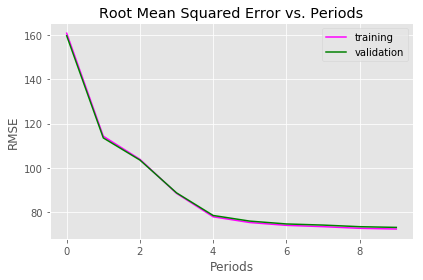

In [11]:
_ = train_nn_regressor_model(
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps = 2000,
    batch_size = 50,
    hidden_units = [10, 10],
    training_examples = normalized_training_examples,
    training_targets = training_targets,
    validation_examples = normalized_validation_examples,
    validation_targets = validation_targets
)

### Adagrad Optimizer

Training model...
  RMSE (on training data & validation data): 
    Period 01 : 80.97	81.46
    Period 02 : 72.74	73.44
    Period 03 : 73.34	73.97
    Period 04 : 70.21	71.26
    Period 05 : 73.27	74.45
    Period 06 : 69.40	70.55
    Period 07 : 69.34	70.47
    Period 08 : 70.26	71.44
    Period 09 : 69.80	71.03
    Period 10 : 68.63	69.80
Model training finished.
Final RMSE (on training data): 68.62770398701741
Final RMSE (on validation data): 69.80045852381694


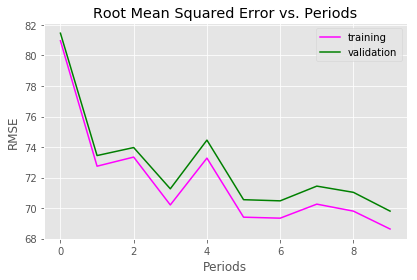

In [14]:
_ = train_nn_regressor_model(
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.5),
    steps = 500,
    batch_size = 100,
    hidden_units = [10, 10],
    training_examples = normalized_training_examples,
    training_targets = training_targets,
    validation_examples = normalized_validation_examples,
    validation_targets = validation_targets
)

### Adam Optimizer

Training model...
  RMSE (on training data & validation data): 
    Period 01 : 232.41	231.34
    Period 02 : 196.08	195.02
    Period 03 : 119.14	118.22
    Period 04 : 111.97	111.30
    Period 05 : 103.06	102.66
    Period 06 : 91.80	91.83
    Period 07 : 79.35	79.84
    Period 08 : 72.69	73.35
    Period 09 : 71.23	72.03
    Period 10 : 70.30	71.32
Model training finished.
Final RMSE (on training data): 70.30062764327243
Final RMSE (on validation data): 71.31957725812786


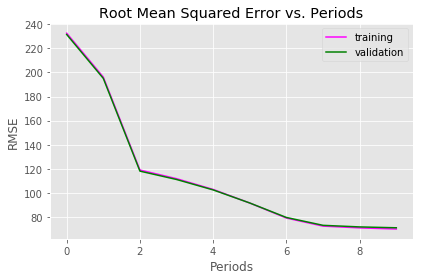

In [15]:
_ = train_nn_regressor_model(
    my_optimizer = tf.train.AdamOptimizer(learning_rate=0.009),
    steps = 500,
    batch_size = 100,
    hidden_units = [10, 10],
    training_examples = normalized_training_examples,
    training_targets = training_targets,
    validation_examples = normalized_validation_examples,
    validation_targets = validation_targets
)

### Histograms of Normalized Training Examples

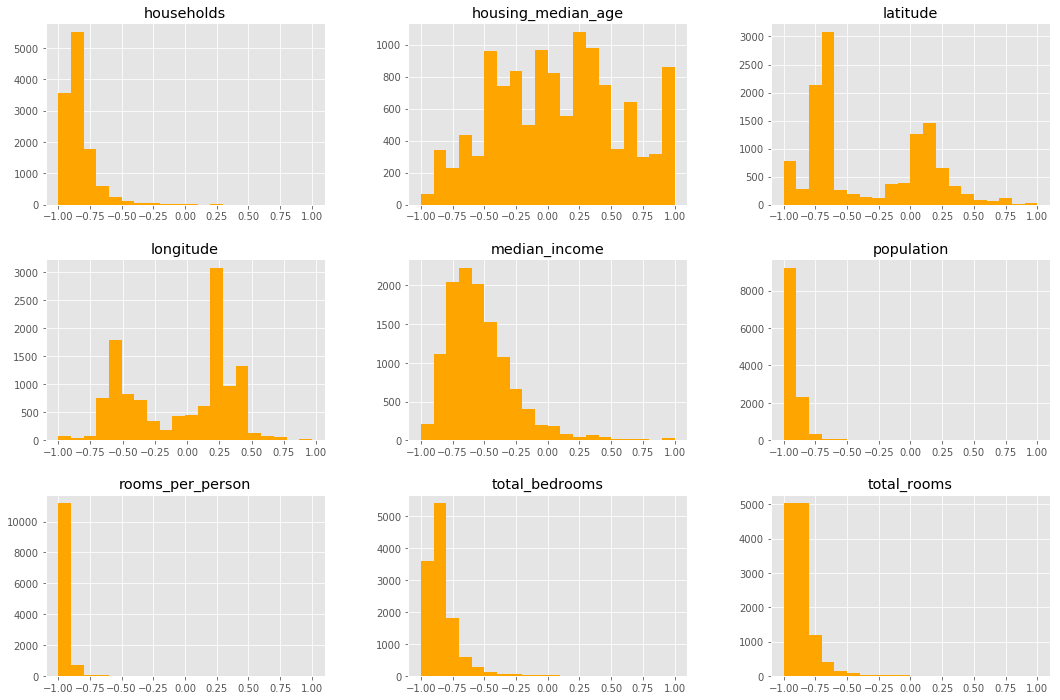

In [27]:
normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10, color="orange")
plt.show()

### Alternative Normalization Methods

In [28]:
def log_normalize(series):
    return series.apply(lambda x: math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x: (min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
    mean = series.mean()
    std_dev = series.std()
    return series.apply(lambda x: (x - mean) / std_dev)

def binary_threshold(series, threshold):
    return series.apply(lambda x: (1 if x > threshold else 0))